In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold, SequentialFeatureSelector, SelectPercentile, SelectFpr, SelectFdr, SelectFwe, RFE 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew
import numpy as np
from pathlib import Path
import matplotlib.patches as mpatches
import joblib
from joblib import dump
import shap

sys.path.append('../../../')

from src.emotion.utils.constants import MODEL_DIR
from src.emotion.prediction.aggregates.train import HyperparaSearch
from src.emotion.prediction.aggregates.models import MODELS
from src.emotion.prediction.aggregates.classifier import CLASSIFIER

# %matplotlib inline
# plt.style.use('ggplot')

# # set default color cycle
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset_small.csv')

In [3]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [4]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(103, 135)

In [5]:
# Specify the name of the file
filename = "facial_features.csv"
feats = df.drop(columns=['ClassID'])
# Save the DataFrame to CSV
# Suppose 'Email-Address' and 'B' are the columns you want to move to the front
cols_to_move = ['E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname']

# Get the rest of the columns and concatenate two lists
new_order = cols_to_move + [col for col in feats.columns if col not in cols_to_move]

# Reorder the DataFrame
feats = feats[new_order]

feats.to_csv(filename, index=False)

In [6]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)


(103, 132)


In [7]:
# Detect outliers
# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(103, 132)
(103, 132)


In [8]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [9]:
# from sklearn.neighbors import LocalOutlierFactor
# # define the model
# print(X.shape)
# lof = LocalOutlierFactor(contamination=0.05)
# # fit the model
# yhat = lof.fit_predict(X)

# # select all rows that are not outliers
# mask = yhat != -1
# X = X[mask]
# Y = Y[mask]
# print(X.shape)

In [85]:
# Scale Features
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler()

# Calculate skewness of each feature
skewness = skew(X, axis=0)

# Create empty list to store scaled features
scaled_features = []
# Create an empty dictionary to store scalers
scalers_dict = {}

# Scale features using appropriate scaler
for feat, s in zip(X.columns, skewness):
    if abs(s) < 0.5:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    scaled_feat = scaler.fit_transform(X[feat].values.reshape(-1, 1)).flatten()
    scaled_features.append(pd.Series(scaled_feat, name=feat))
    # Add the trained scaler to the dictionary
    scalers_dict[feat] = scaler

# Concatenate scaled features into new DataFrame
scaled_X = pd.concat(scaled_features, axis=1)

# Fit the scaler to the dataframe and transform the dataframe
scaled_Y = pd.DataFrame(minmax_scaler.fit_transform(Y), columns=['P', 'E', 'R', 'M', 'A'])

# Add the trained target scaler to the dictionary
scalers_dict['target_scaler'] = minmax_scaler

path = "/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/" + "scalers_dict.joblib"
# Now save the dictionary with joblib
dump(scalers_dict, path)

['/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/scalers_dict.joblib']

In [84]:
scalers_dict

{'Angry__median': RobustScaler(),
 'Angry__mean': RobustScaler(),
 'Angry__standard_deviation': RobustScaler(),
 'Angry__maximum': RobustScaler(),
 'Angry__minimum': RobustScaler(),
 'Angry__Slope': RobustScaler(),
 'Angry__P_25': RobustScaler(),
 'Angry__P_75': RobustScaler(),
 'Disgust__median': RobustScaler(),
 'Disgust__mean': RobustScaler(),
 'Disgust__standard_deviation': RobustScaler(),
 'Disgust__maximum': RobustScaler(),
 'Disgust__minimum': RobustScaler(),
 'Disgust__Slope': RobustScaler(),
 'Disgust__P_25': RobustScaler(),
 'Disgust__P_75': RobustScaler(),
 'Happy__median': RobustScaler(),
 'Happy__mean': RobustScaler(),
 'Happy__standard_deviation': StandardScaler(),
 'Happy__maximum': StandardScaler(),
 'Happy__minimum': RobustScaler(),
 'Happy__Slope': RobustScaler(),
 'Happy__P_25': RobustScaler(),
 'Happy__P_75': RobustScaler(),
 'Sad__median': RobustScaler(),
 'Sad__mean': RobustScaler(),
 'Sad__standard_deviation': RobustScaler(),
 'Sad__maximum': StandardScaler(),
 '

In [20]:
def plot_correlation_matrix(matrix, title):
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=0.7)
    sns.heatmap(corr_matrix, cmap="YlGnBu")
    
    # path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/appendix/"
    # image = path + title + ".pdf"
    # plt.savefig(image, bbox_inches='tight', dpi=300)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, scaled_Y, test_size=0.2, random_state=42)

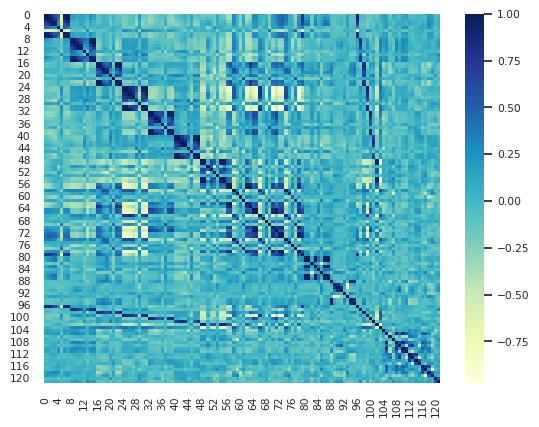

In [22]:
title = "corr_before"
plot_correlation_matrix(X_train, title=title)

In [23]:
# # Calculate correlation matrix
# corr_matrix = X_train.corr().abs()

# # Create a DataFrame from the correlation matrix
# corr_df = corr_matrix.unstack().reset_index()

# # Rename columns
# corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

# # Remove self correlations by excluding cases where variables are correlated with themselves
# corr_df = corr_df[corr_df['Feature1'] != corr_df['Feature2']]

# # Drop duplicates
# corr_df = corr_df.drop_duplicates()

# # Sort by absolute correlation
# corr_df['AbsCorrelation'] = np.abs(corr_df['Correlation'])
# corr_df.sort_values(by='AbsCorrelation', ascending=False, inplace=True)

# # Identify highly correlated feature pairs
# high_corr_pairs = []
# for index, row in corr_df.iterrows():
#     if row['AbsCorrelation'] > 0.9:
#         high_corr_pairs.append((row['Feature1'], row['Feature2']))

# # From each pair, remove the feature with lower average correlation
# to_drop = set()
# for pair in high_corr_pairs:
#     feature1_avg_corr = corr_df[(corr_df['Feature1'] == pair[0]) | (corr_df['Feature2'] == pair[0])]['AbsCorrelation'].mean()
#     feature2_avg_corr = corr_df[(corr_df['Feature1'] == pair[1]) | (corr_df['Feature2'] == pair[1])]['AbsCorrelation'].mean()

#     if feature1_avg_corr < feature2_avg_corr:
#         to_drop.add(pair[0])
#     else:
#         to_drop.add(pair[1])

# # Drop highly correlated features from original dataframe
# for feature in to_drop:
#     if feature in X_train.columns:
#         X_train = X_train.drop(columns=[feature])

# print(X_train)


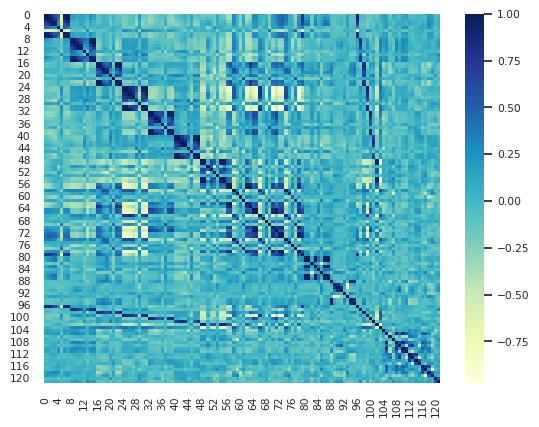

In [24]:
title = "corr_after"
plot_correlation_matrix(X_train, title=title)

In [25]:
def get_selected_voting_features_combined(Y, X, filter_methods, wrapper_methods, k):
    #np.random.seed(1)
    
    feature_counts = np.zeros(X.shape[1])

    # Apply filter methods
    for _, method in filter_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        print(len(selected_i))
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1

    # Apply wrapper methods
    for _, method in wrapper_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
    
    # Get the indices of the top k features with the most counts
    #selected_features = np.argsort(feature_counts)[-k:]
    selected_features = np.where(feature_counts >= k)[0]
    print(np.sort(feature_counts))
    
    return selected_features

In [26]:
# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=8),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=8),
    'variance_threshold': VarianceThreshold(threshold=1.5),
    'select_percentile': SelectPercentile(f_regression, percentile=10),
    'select_fpr': SelectFpr(f_regression, alpha=0.15),
    'select_fdr': SelectFdr(f_regression, alpha=0.99),
    'select_fwe': SelectFwe(f_regression, alpha=1.0),
    #'rfe_regression': RFEC(LinearRegression(), n_features_to_select=8),
}

wrapper_methods = {
    #'sfs_regression': SequentialFeatureSelector(LinearRegression(), n_features_to_select=8, direction='forward', n_jobs=-1),
    #'sbs_regression': SequentialFeatureSelector(LinearRegression(), n_features_to_select=8, direction='backward', n_jobs=-1),
}


# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_combined(Y_train.iloc[:, i], X_train, filter_methods, wrapper_methods, k=4)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features
    
# Save the dictionary with joblib
path = "/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/" + "selected_features.joblib"
dump(perma_dict, path)

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])


8
8
33
13
12
43
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4.
 5. 5.]
8
8
33
13
20
121
0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 5. 5.
 5. 5.]
8
8
33
13
27
114
2
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [27]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    #X_test_final = X_test.iloc[:, list(set(selected_features))]
    column_names = X_train_final.columns.tolist()
    X_test_final = X_test[column_names]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)


P : ['Angry__Slope', 'Fear__max_count', 'Degree Centrality', 'Dominance__standard_deviation', 'Dominance__minimum', 'GazeDifference_Max', 'Velocity__median', 'Velocity__mean', 'Velocity__Slope']
E : ['Gazes_Mean', 'Gazes_Min', 'GazeDifference_Mean', 'GazeDifference_Min', 'Neutral__standard_deviation', 'Valence__median', 'Valence__mean', 'Valence__maximum', 'Sad__P_25', 'Valence__P_75']
R : ['Brightness__median', 'GazeDifference_Mean', 'GazeDifference_Max', 'Brightness__P_75', 'Velocity__median', 'Velocity__minimum', 'Velocity__P_25', 'Velocity__P_75']
M : ['Degree Centrality', 'Dominance__standard_deviation', 'Dominance__Slope', 'Dominance__P_25', 'GazeDifference_Mean', 'Sad__Slope', 'Happy__maximum', 'GazeDifference_Max', 'Valence__Slope']
A : ['Sad__max_count', 'Dominance__median', 'Dominance__mean', 'Dominance__P_25', 'Sad__median', 'Sad__mean', 'Valence__median', 'Sad__P_75', 'Valence__P_75']


In [28]:
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    Lasso,
    LinearRegression,
    Ridge,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

random_state = 42

MODELS = [
    {
        "name": "MLPRegressor",
        "model": MLPRegressor(max_iter=2000),
        "params": {
            "hidden_layer_sizes": [(64, 32), (128, 64)],
            "alpha": [0.001, 0.01, 0.1],
            "learning_rate_init": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "KNeighborsRegressor",
        "model": KNeighborsRegressor(),
        "params": {"n_neighbors": [1, 5, 10, 15, 20]},
    },
    {
        "name": "DecisionTreeRegressor",
        "model": DecisionTreeRegressor(),
        "params": {"max_depth": range(2, 11)},
        "random_state": [random_state],
    },
    {
        "name": "RandomForestRegressor",
        "model": RandomForestRegressor(),
        "params": {"n_estimators": [50, 100, 200, 400], "max_depth": range(2, 6)},
        "random_state": [random_state],
    },
    {
        "name": "ExtraTreesRegressor",
        "model": ExtraTreesRegressor(),
        "params": {"n_estimators": [50, 100, 200, 400], "max_depth": range(2, 6)},
        "random_state": [random_state],
    },
    {
        "name": "GradientBoostingRegressor",
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "AdaBoostRegressor",
        "model": AdaBoostRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "learning_rate": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "SVR",
        "model": SVR(),
        "params": {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1.0, 10.0],
            "epsilon": [0.01, 0.1, 1.0],
        },
    },
    {
        "name": "LinearRegression",
        "model": LinearRegression(),
        "params": {},
    },
    {
        "name": "Ridge",
        "model": Ridge(),
        "params": {"alpha": [0.001, 0.01, 0.1, 1.0]},
        "random_state": [random_state],
    },
    {
        "name": "Lasso",
        "model": Lasso(),
        "params": {"alpha": [0.001, 0.01, 0.1, 1.0]},
        "random_state": [random_state],
    },
    {
        "name": "ElasticNet",
        "model": ElasticNet(),
        "params": {"alpha": [0.001, 0.01, 0.1, 1.0], "l1_ratio": [0.1, 0.5, 0.9]},
        "random_state": [random_state],
    },
    {
        "name": "BayesianRidge",
        "model": BayesianRidge(),
        "params": {
            "alpha_1": [0.001, 0.01, 0.1, 1.0],
            "alpha_2": [0.001, 0.01, 0.1, 1.0],
        },
    },
    {
        "name": "CatBoostRegressor",
        "model": CatBoostRegressor(verbose=False),
        "params": {
            "iterations": [50, 100, 200, 400],
            "depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1, 1.0],
            "random_state": [random_state],
        },
    },
    {
        "name": "XGBRegressor",
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
]

In [29]:
SAVE_DIR = Path("/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small")

eval_metric = "mean_absolute_error"

In [30]:
models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "SVR", "Lasso", "GradientBoostingRegressor"]
#models_to_drop = ["MLPRegressor", "KNeighborsRegressor"]

for name in models_to_drop:
    for i in range(len(MODELS)):
        if MODELS[i]["name"] == name:
            del MODELS[i]
            break
        
for model in MODELS:
    print(model["name"])

RandomForestRegressor
ExtraTreesRegressor
AdaBoostRegressor
LinearRegression
Ridge
ElasticNet
BayesianRidge
CatBoostRegressor
XGBRegressor


In [31]:
results_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR / perma_dim
    X_train = X_final["train"]
    search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")  
    results = search.run(X_train, Y_train[perma_dim], save=True)
    results_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P
Models for RandomForestRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/RandomForestRegressor.joblib
Models for ExtraTreesRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/ExtraTreesRegressor.joblib
Models for AdaBoostRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/AdaBoostRegressor.joblib
Models for LinearRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/LinearRegression.joblib
Models for Ridge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/Ridge.joblib
Models for ElasticNet saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/ElasticNet.joblib
Models for BayesianRidge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/BayesianRidge.joblib
Models for CatBoostRegressor saved to /home/moritz/

In [58]:
best_models = {}

for perma_dim, results in results_dict.items():
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    if perma_dim == "E":
        best_models[perma_dim] = "AdaBoostRegressor"
    # print(perma_dim)
    # print(f"Best model: {best_model['name']}")
    # print(f"Best params: {best_model['params']}")
    # print(f"Best Score: {best_model['score']}")
    else:
       best_models[perma_dim] = best_model['name']

# Save the best models with joblib
path = "/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/" + "best_models.joblib"
dump(best_models, path)

['/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/best_models.joblib']

In [59]:
# best_models = {}

# for perma_dim, results in results_dict.items():
#     flattened_results = [item for sublist in results for item in sublist]
#     best_model = min(flattened_results, key=lambda x: x['score'])
#     #if perma_dim == "P":
#     #    best_models[perma_dim] = "DecisionTreeClassifier"
#     # print(perma_dim)
#     # print(f"Best model: {best_model['name']}")
#     # print(f"Best params: {best_model['params']}")
#     # print(f"Best Score: {best_model['score']}")
#     #else:
#     best_models[perma_dim] = best_model['name']

In [60]:
def load_best_model(file_path: Path):

    models = {}

    if file_path.is_file():
        model = joblib.load(file_path)

        models[str(file_path.stem)] = model

    return models

In [61]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR / perma_dim / (best_models[perma_dim] + ".joblib")
    models = load_best_model(models_path)
    perma_models[perma_dim] = models

In [62]:
perma_models

{'P': {'CatBoostRegressor': [GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                estimator=<catboost.core.CatBoostRegressor object at 0x7f5c0c672d10>,
                param_grid={'depth': range(2, 6),
                            'iterations': [50, 100, 200, 400],
                            'learning_rate': [0.001, 0.01, 0.1, 1.0],
                            'random_state': [42]},
                scoring='neg_mean_absolute_error')]},
 'E': {'AdaBoostRegressor': [GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                estimator=AdaBoostRegressor(),
                param_grid={'learning_rate': [0.001, 0.01, 0.1],
                            'n_estimators': [50, 100, 200, 400],
                            'random_state': [42]},
                scoring='neg_mean_absolute_error')]},
 'R': {'BayesianRidge': [GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                estimator=BayesianRidge(),
                para

In [63]:
# perma_models = {}

# for perma_dim in ["P", "E", "R", "M", "A"]:
#     models_path = SAVE_DIR / perma_dim
#     models = load_models(models_path)
#     perma_models[perma_dim] = models

In [64]:
def print_models(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        if model_name == "CatBoostRegressor":
            print(model.get_params())
        else:
            print(model)
        
for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    print_models(models, X_test, Y_test[dim])

{'iterations': 50, 'learning_rate': 0.01, 'depth': 4, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 42}
AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=42)
BayesianRidge(alpha_1=1.0, alpha_2=1.0)
ElasticNet(alpha=0.01, l1_ratio=0.9)
BayesianRidge(alpha_1=0.001, alpha_2=0.1)


In [65]:
def generate_predictions(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate mean squared error and mean absolute error
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        results[model_name] = {"mae": mae, "mse": mse, "y_pred": y_pred}
    return results

In [66]:
# def generate_shap_values(models, X):
#     for model_name, mae_grid_search in models.items():
#         model = mae_grid_search[0].best_estimator_
#         print(model_name)

#         if model_name in ["ElasticNet", "Lasso", "Ridge", "LinearRegression", "BayesianRidge"]:
#             explainer = shap.LinearExplainer(model, X, feature_names=X.columns)
#             shap_values = explainer(X)
#             shap.summary_plot(shap_values, X)
#         elif model_name in ["AdaBoostRegressor"]:
#             explainer = shap.SamplingExplainer(model.predict, X)
#             shap_values = explainer(X)
#             shap.summary_plot(shap_values, X)
#         else:
#             explainer = shap.Explainer(model, feature_names=X.columns)
#             shap_values = explainer(X)
#             shap.summary_plot(shap_values, X)


In [67]:
# for dim, models in perma_models.items():
#     print(dim)
#     X_test = feature_sets[dim]["train"]
#     generate_shap_values(models, X_test)

In [68]:
def generate_shap_values_and_ranks(dim, models, X):
    feature_rankings = {}

    for i, (model_name, mae_grid_search) in enumerate(models.items()):
        model = mae_grid_search[0].best_estimator_
        print(model_name)
        
        if model_name in ["ElasticNet", "Lasso", "Ridge", "LinearRegression", "BayesianRidge"]:
            explainer = shap.LinearExplainer(model, X, feature_names=X.columns)
        elif model_name in ["AdaBoostRegressor", "SVR"]:
            explainer = shap.SamplingExplainer(model.predict, X)
        else:
            explainer = shap.Explainer(model, feature_names=X.columns)

        shap_values = explainer(X)
        shap.summary_plot(shap_values, X, plot_size=(13, 3), plot_type='violin', show=False)
        # path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results/small_regr_shap"
        # image = path + "/" + dim[i].lower() + "_small_regr.pdf"
        # plt.savefig(image, bbox_inches='tight', dpi=300)
        # plt.close()  # close the plot

        # Get the mean absolute shap values for each feature
        mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

        # Create a DataFrame for easy sorting and manipulation
        feature_shap_df = pd.DataFrame(list(zip(X.columns, mean_abs_shap_values)), 
                                       columns=['feature','mean_abs_shap'])

        # Sort by the mean absolute shap value and add rank column
        feature_shap_df = feature_shap_df.sort_values('mean_abs_shap', ascending=False)
        feature_shap_df['rank'] = range(1, len(feature_shap_df) + 1)
        
        # Store the ranking in the dictionary
        feature_rankings[model_name] = feature_shap_df[['feature', 'rank']].set_index('feature').to_dict()['rank']

    return feature_rankings

def aggregate_ranks(feature_rankings_perma):
    aggregated_ranks = {}
    for dim, feature_rankings in feature_rankings_perma.items():
        # Calculate the total rank and count for each feature
        total_ranks = {}
        counts = {}
        for model_name, ranks in feature_rankings.items():
            for feature, rank in ranks.items():
                if feature in total_ranks:
                    total_ranks[feature] += rank
                    counts[feature] += 1
                else:
                    total_ranks[feature] = rank
                    counts[feature] = 1

        # Calculate the mean rank for each feature
        mean_ranks = {feature: total_ranks[feature] / counts[feature] for feature in total_ranks}

        # Sort the features by their mean ranks
        sorted_features = sorted(mean_ranks, key=mean_ranks.get)
        aggregated_ranks[dim] = sorted_features

    return aggregated_ranks


P
CatBoostRegressor


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names


E
AdaBoostRegressor


  0%|          | 0/82 [00:00<?, ?it/s]X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted wi

R
BayesianRidge


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


M
ElasticNet


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


A
BayesianRidge


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


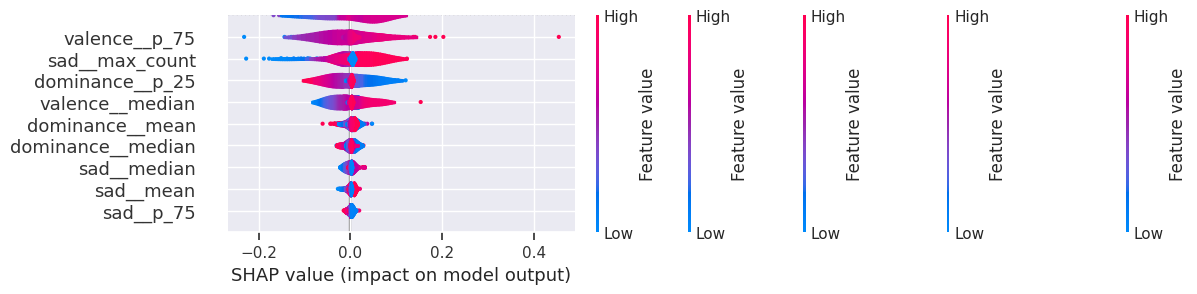

In [69]:
feature_rankings_perma = {}
for dim, models in perma_models.items():
    print(dim)
    X_test = feature_sets[dim]["train"]
    X_test.columns = [col.lower() for col in X_test.columns]
    X_test.rename(columns={'degree centrality': 'out_degree_centrality'}, inplace=True)
    X_test.rename(columns=lambda x: x.split('_')[0].replace('gazedifference', 'gaze_difference') + '_' + x.split('_')[1] if 'gazedifference_' in x else x, inplace=True)

    feature_rankings_perma[dim] = generate_shap_values_and_ranks(dim, models, X_test)

aggregated_ranks = aggregate_ranks(feature_rankings_perma)

In [70]:
def calculate_importance(feature_rankings_perma):
    # Initialize total ranks and counts dictionaries
    total_ranks = {}
    counts = {}

    # Iterate over all dimensions
    for dim, feature_rankings in feature_rankings_perma.items():
        # Iterate over all features in this dimension
        for rank, feature in enumerate(feature_rankings, 1):
            # Update total ranks and counts
            if feature in total_ranks:
                val = 1.1 - 0.1*rank
                total_ranks[feature] += val
                counts[feature] += 1
            else:
                val = 1.1 - 0.1*rank
                total_ranks[feature] = val
                counts[feature] = 1


    # Calculate the average rank for each feature
    #avg_ranks = {feature: total_ranks[feature] / counts[feature] for feature in total_ranks}

    return counts, total_ranks

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25]),
 [Text(0.0, 0, '0.00'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.50'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.00'),
  Text(1.25, 0, '1.25'),
  Text(1.5, 0, '1.50'),
  Text(1.75, 0, '1.75'),
  Text(2.0, 0, '2.00'),
  Text(2.25, 0, '2.25')])

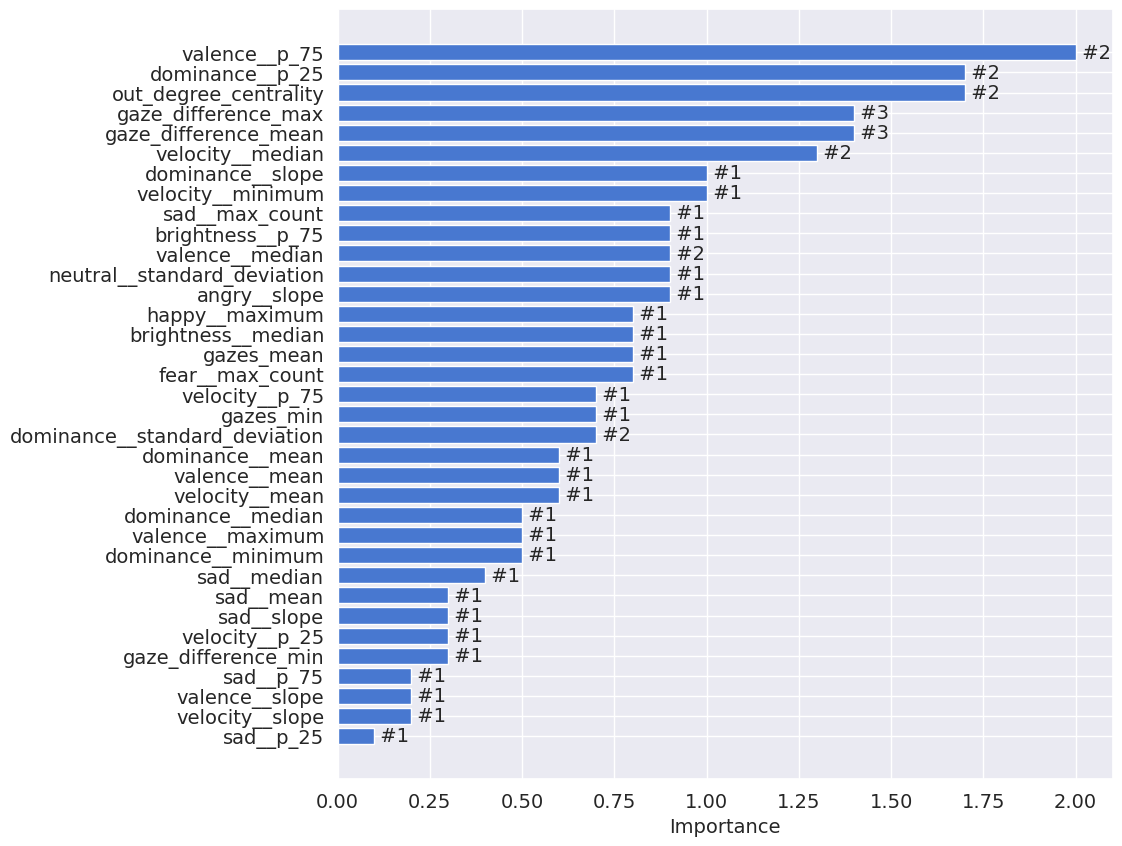

In [71]:
# Apply your function to the data
counts, total_ranks = calculate_importance(aggregated_ranks)

# Sort the dictionary by value
sorted_importance = sorted(total_ranks.items(), key=lambda item: item[1])

# Unpack names and values
names, values = zip(*sorted_importance)

# Create a color palette
palette = sns.color_palette("muted")

fig, ax = plt.subplots(figsize=(10, 10))

# Apply color palette
ax.set_prop_cycle(color=palette)

# Create a horizontal bar plot
ax.barh(names, values)

# Add counts on top of the bars
for i, name in enumerate(names):
    count = counts[name]
    value = values[i]
    ax.text(value, i, f' #{count}', va='center', fontsize=14)  # increase fontsize here

ax.set_xlabel('Importance', fontsize=14)  # increase fontsize here
plt.yticks(fontsize=14) 
plt.xticks(fontsize=14) 


# path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
# image = path + "/imp_regr.pdf"
# plt.savefig(image, bbox_inches='tight', dpi=300)


In [72]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    print(X_test.columns)
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results
    # for model_name, result in results.items():
    #     print(f"{dim} - {model_name}: MAE - {result['mae']}, MSE - {result['mse']}")
    

Index(['Angry__Slope', 'Fear__max_count', 'Degree Centrality',
       'Dominance__standard_deviation', 'Dominance__minimum',
       'GazeDifference_Max', 'Velocity__median', 'Velocity__mean',
       'Velocity__Slope'],
      dtype='object')
Index(['Gazes_Mean', 'Gazes_Min', 'GazeDifference_Mean', 'GazeDifference_Min',
       'Neutral__standard_deviation', 'Valence__median', 'Valence__mean',
       'Valence__maximum', 'Sad__P_25', 'Valence__P_75'],
      dtype='object')
Index(['Brightness__median', 'GazeDifference_Mean', 'GazeDifference_Max',
       'Brightness__P_75', 'Velocity__median', 'Velocity__minimum',
       'Velocity__P_25', 'Velocity__P_75'],
      dtype='object')
Index(['Degree Centrality', 'Dominance__standard_deviation',
       'Dominance__Slope', 'Dominance__P_25', 'GazeDifference_Mean',
       'Sad__Slope', 'Happy__maximum', 'GazeDifference_Max', 'Valence__Slope'],
      dtype='object')
Index(['Sad__max_count', 'Dominance__median', 'Dominance__mean',
       'Dominance__P_

In [73]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["mae"] < curr_mae:
            curr_mae = results[model]["mae"]
            best_results[dim] = {"model": model, "mae": results[model]["mae"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'CatBoostRegressor', 'mae': 0.16275967134819583, 'preds': array([0.63691451, 0.66022882, 0.64563508, 0.64821333, 0.65351227,
       0.67184816, 0.63915742, 0.63275064, 0.63027729, 0.64744491,
       0.62598812, 0.64343629, 0.64664541, 0.63100695, 0.65204911,
       0.62665459, 0.64367836, 0.63831671, 0.64903993, 0.64488893,
       0.64299462])}, 'E': {'model': 'AdaBoostRegressor', 'mae': 0.2208183941429095, 'preds': array([0.42      , 0.66      , 0.56551724, 0.64      , 0.60625   ,
       0.69791667, 0.5       , 0.784375  , 0.63846154, 0.64193548,
       0.455     , 0.584375  , 0.61666667, 0.62083333, 0.39444444,
       0.56551724, 0.62083333, 0.35789474, 0.61666667, 0.57692308,
       0.67674419])}, 'R': {'model': 'BayesianRidge', 'mae': 0.13479393045031146, 'preds': array([0.68364273, 0.78401259, 0.7229755 , 0.6848788 , 0.78903999,
       0.76324368, 0.78517024, 0.80697964, 0.70584742, 0.73604714,
       0.58654509, 0.68595584, 0.75563039, 0.67700051, 0.75794652,
    

In [74]:
# best_feats_dict = {}

# for dim, results in results_dict.items():
#     best_feats_dict[dim] = {model[0]['name']: {"feat_imp": model[0]['best_feats'], "score": model[0]["score"]}  for model in results}

# best_feats_dict_dim = {}
    
# for dim in ['P', 'E', 'R', 'M', 'A']:
#     model = best_results[dim]["model"]
#     feat_imp = abs(best_feats_dict[dim][model]["feat_imp"])
#     best_feats_dict_dim[dim] = feat_imp

# best_feats_dict_dim


In [75]:
# ranked_feats_dict = {}

# for (dim, feat_imp_vals), (dim, X_final) in zip(best_feats_dict_dim.items(), feature_sets.items()):
#     # Map the feature importance values with the feature list using a dictionary comprehension
#     column_names = X_final["train"].columns.tolist()
#     feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
#     # Rank the features by their importance value in descending order
#     ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
#     ranked_feats_dict[dim] = ranked_feats


In [76]:
# #Separate the feature names and importance scores for each dimension PERMA
# P_features, P_scores = zip(*ranked_feats_dict["P"])
# E_features, E_scores = zip(*ranked_feats_dict["E"])
# R_features, R_scores = zip(*ranked_feats_dict["R"])
# M_features, M_scores = zip(*ranked_feats_dict["M"])
# A_features, A_scores = zip(*ranked_feats_dict["A"])


# #Create a bar plot for each dimension PERMA
# fig, axs = plt.subplots(1, 5, figsize=(18, 6))
# axs[0].bar(P_features, P_scores)
# axs[0].set_title("P")
# axs[1].bar(E_features, E_scores)
# axs[1].set_title("E")
# axs[2].bar(R_features, R_scores)
# axs[2].set_title("R")
# axs[3].bar(M_features, M_scores)
# axs[3].set_title("M")
# axs[4].bar(A_features, A_scores)
# axs[4].set_title("A")

# #Set common axis labels and title
# fig.suptitle("Feature Importance for each PERMA Dimension", fontsize=16)
# for ax in axs:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

In [77]:
# Baseline:
Y_baseline = np.full_like(Y_test, Y_test.mean(axis=0).transpose())
mae_baseline = mean_absolute_error(Y_test, Y_baseline, multioutput='raw_values')

print(f"Baseline MAE for each dimension: {mae_baseline}")

Baseline MAE for each dimension: [0.16439909 0.20816327 0.14739229 0.20272109 0.1462585 ]


Text(0, 0.5, 'MAE scores')

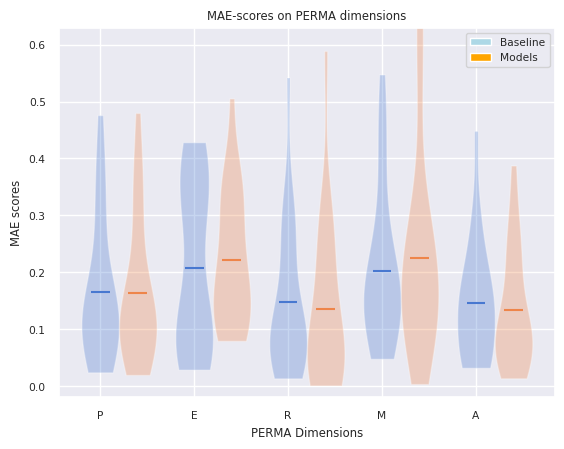

In [78]:
# Calculate the errors between the actual values and the baseline predictions
baseline_errors = abs(Y_test - Y_baseline)

# Calculate the errors for each model and each dimension
model_errors = pd.DataFrame()

# Calculate the errors for each model and each dimension
for dim in ['P', 'E', 'R', 'M', 'A']:
    err = abs(Y_test[dim] - best_results[dim]['preds'])
    errors = pd.DataFrame({'errors': err})
    model_errors = pd.concat([model_errors, errors], axis=1)

# Concatenate baseline and model errors
all_errors = [baseline_errors, model_errors]

# Create a combined boxplot
fig, ax = plt.subplots()
palette = sns.color_palette("muted")
ax.set_prop_cycle(color=palette)
colors = ['lightblue', 'orange']
labels = ['Baseline', 'Models']

for i, error_df in enumerate(all_errors):
    position = np.arange(1, len(error_df.columns) + 1) + (i * 0.4)
    #ax.boxplot(error_df, positions=position, widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.violinplot(error_df, positions=position, widths=0.4, showmedians=False, showextrema=False, showmeans=True)

# Define the labels for the x-axis
perma = ['P', 'E', 'R', 'M', 'A']

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(1, len(perma) + 1))
ax.set_xticklabels(perma)
ax.set_ylim(-0.02, 0.63)

# Create the legend patches and labels
patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the plot
#ax.legend()
ax.set_title('MAE-scores on PERMA dimensions')
ax.legend(handles=patches, loc='upper right')
ax.set_xlabel('PERMA Dimensions')
ax.set_ylabel('MAE scores')

(0.0, 0.3)

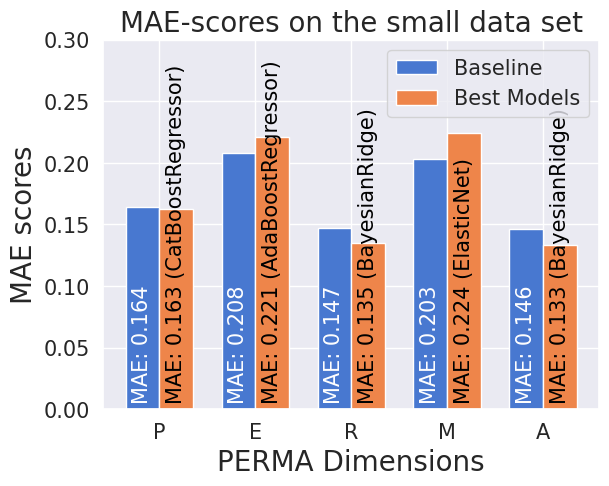

In [79]:

# Print the best model for each PERMA dimension
best_mae_values = [v['mae'] for v in best_results.values()]
#best_mae_values = [0.162, 0.205, 0.131, 0.224, 0.133]

# regression big simulation
#best_mae_values = [0.143, 0.241, 0.168, 0.212, 0.138]
#models = ["BayesianRidge", "BayesianRidge", "BayesianRidge", "BayesianRidge", "BayesianRidge"]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
palette = sns.color_palette("muted")
ax.set_prop_cycle(color=palette)
ax.bar(np.arange(len(perma_dimensions)), mae_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_mae_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimensions', fontsize=20)

# Set the y-axis label and limits
ax.set_ylabel('MAE scores', fontsize=20)
ax.set_ylim([0, max(np.max(mae_baseline), np.max(best_mae_values))*1.1])
ax.tick_params(axis='both', which='major', labelsize=15)

# Add the model names and MAE values above each bar
for i, v in enumerate(mae_baseline):
    ax.text(i, 0.005, f"MAE: {v:.3f}", rotation=90, ha='center', va='bottom', fontsize=15, color='white')
    model = best_results[perma_dimensions[i]]['model']
    #model = models[i]
    ax.text(i+bar_width, 0.005, f"MAE: {best_mae_values[i]:.3f} ({model})", rotation=90, ha='center', va='bottom', fontsize=15, color='black')

# Add a legend and title
ax.legend(fontsize=15)
ax.set_title('MAE-scores on the small data set', fontsize=20)
ax.set_ylim([0, 0.3])

# path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
# image = path + "/mae_small.pdf"
# plt.savefig(image, bbox_inches='tight', dpi=300)

In [80]:
Y_pred = pd.DataFrame()

for dim in ['P', 'E', 'R', 'M', 'A']:
    err = best_results[dim]['preds']
    errors = pd.DataFrame({dim: err})
    Y_pred = pd.concat([Y_pred, errors], axis=1)

# Unscale the data back to the original scale
Y_preds = pd.DataFrame(minmax_scaler.inverse_transform(Y_pred), columns=['P', 'E', 'R', 'M', 'A'])
Y_tests = pd.DataFrame(minmax_scaler.inverse_transform(Y_test), columns=['P', 'E', 'R', 'M', 'A'])
Y_baselines = pd.DataFrame(minmax_scaler.inverse_transform(Y_baseline), columns=['P', 'E', 'R', 'M', 'A'])

In [81]:
Y_baseline_df = pd.DataFrame(Y_baseline, columns=['P', 'E', 'R', 'M', 'A'])

print(Y_pred.min())
print(Y_pred.max())
print(Y_test.min())
print(Y_test.max())

P    0.625988
E    0.357895
R    0.586545
M    0.296793
A    0.527263
dtype: float64
P    0.671848
E    0.784375
R    0.807395
M    0.895909
A    0.762788
dtype: float64
P    0.166667
E    0.200000
R    0.166667
M    0.000000
A    0.250000
dtype: float64
P    1.0
E    1.0
R    1.0
M    1.0
A    1.0
dtype: float64


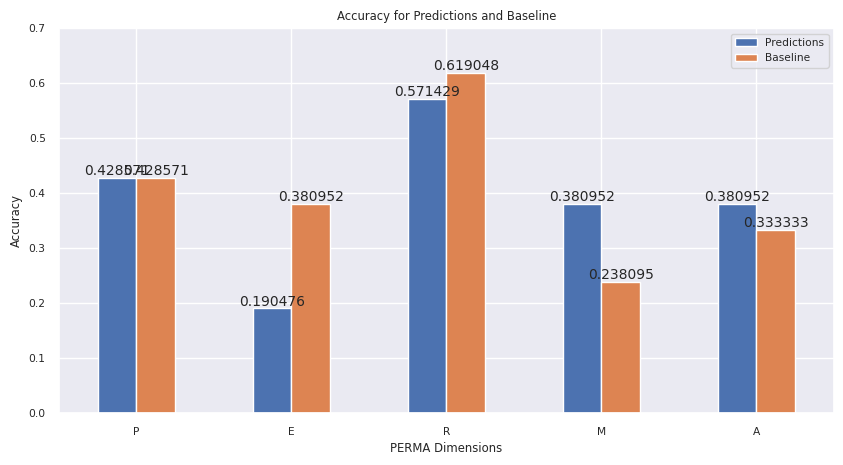

In [82]:
# Define the bins and labels
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

# bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

# Apply the binning
actual_values_bins = Y_test.apply(pd.cut, bins=bins, labels=labels)
predictions_bins = Y_pred.apply(pd.cut, bins=bins, labels=labels)
baseline_bins = Y_baseline_df.apply(pd.cut, bins=bins, labels=labels)

# Reset the indices of both DataFrames
actual_values_bins.reset_index(drop=True, inplace=True)
predictions_bins.reset_index(drop=True, inplace=True)
baseline_bins.reset_index(drop=True, inplace=True)

# Calculate the accuracy for each column
accur_preds = (actual_values_bins == predictions_bins).mean()
accur_baseline = (actual_values_bins == baseline_bins).mean()

# Combine accuracy values into a single DataFrame
accuracy_df = pd.DataFrame({'Predictions': accur_preds, 'Baseline': accur_baseline})

# Plot the accuracy values for predictions and baseline
ax = accuracy_df.plot(kind='bar', figsize=(10, 5))
plt.title('Accuracy for Predictions and Baseline')
plt.xlabel('PERMA Dimensions')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.ylim(0, 0.7)
plt.legend()

# Annotate values on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

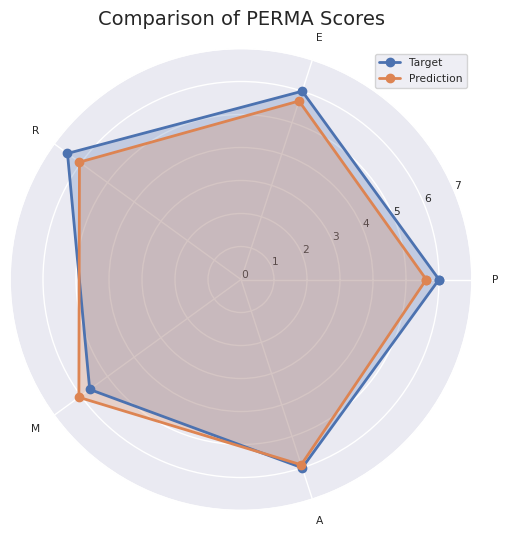

In [83]:
# Define the labels for the radar plots
labels = ['P', 'E', 'R', 'M', 'A']

# Create the figure and subplot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Loop over each row of Y_tests and Y_preds
for i in [np.random.randint(0, len(Y_tests))]:
    # Define the data for the radar plot
    data1 = Y_tests.iloc[i].values
    data2 = Y_preds.iloc[i].values
    #data3 = Y_baselines.iloc[i].values

    # Define the angle for each label
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    # Close the plot
    data1 = np.concatenate((data1, [data1[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    data2 = np.concatenate((data2, [data2[0]]))
    #data3 = np.concatenate((data3, [data3[0]]))

    # Plot the radar plot
    ax.plot(angles, data1, 'o-', linewidth=2, label=f'Target')
    ax.fill(angles, data1, alpha=0.25)
    ax.plot(angles, data2, 'o-', linewidth=2, label=f'Prediction')
    ax.fill(angles, data2, alpha=0.25)
    #ax.plot(angles, data3, 'o-', linewidth=2, label=f'Baseline')
    #ax.fill(angles, data3, alpha=0.25)

# Set the labels
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
plt.yticks(np.arange(0, 7.1, 1.0))
plt.ylim(0, 7)
plt.title('Comparison of PERMA Scores', fontsize=14)
plt.legend()